# Artificial Neural Networks Forecasting methods

Artificial Neural Networks ANNs are very popular in forecasting due to their ability to model complex non-linear relationships between datapoints/variables. They are also flexible in terms of how they can be structured to accepts different formats (univariate, multivariate...), shapes, as well as different outputs. Examples and implementations are shown below

The data preparation part is similar to before

In [ ]:
!pip install -U scikit-learn
!pip install -q -U keras-tuner

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt

np.random.seed(123)
tf.random.set_seed(123)

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

In [7]:
df=pd.read_excel('/content/drive/MyDrive/Traffic.xlsx')

In [8]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
#df_filter.index

Data scaling is a major part of data preparation for neural networks. It is required to make the training process for the weights and biases stable. Big delta's between values can lead to big fluctuations in the trained parameters. Scaling resolves this problem. It is also required in the case of multivariate inputs

In [9]:
Samtest=96
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]


scaler=StandardScaler()
train_scaled=scaler.fit_transform(train[['DL user tput']])
test_scaled=scaler.transform(test[['DL user tput']])


train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

df_filter.loc[train_idx,'scaled_tput']=train_scaled
df_filter.loc[test_idx,'scaled_tput']=test_scaled

Similar to what we did in the previous notebook, we prepare the data set for three scenarios of forecasting: 1step forecasting, Multistep forecasting, and multioutput forecasting

In [10]:
#Prepare data for 1step forecasting
series=df_filter['scaled_tput'].to_numpy()


#T is size of our inputs, which in our case is the previous 96 data points.
#X and Y are empty lists and are placeholders for our input and output

T=96
X=[]
Y=[]

# Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
#append the X and Y lists

for t in range(len(series)-T):
    x=series[t:t+T]
    X.append(x)
    y=series[t+T]
    Y.append(y)

#put back X and Y into arrays and reshape X as T inputs
X=np.array(X).reshape(-1,T)
#X=np.array(X).reshape(-1,T,1)
Y=np.array(Y)


#create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


#Create and index for train and test from the original dataframe.
#Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

train_idx=df_filter.index <= train.index[-1]
test_idx=~train_idx
train_idx[:T]=False



In [11]:
#prepare data for multioutput forecasting
Tx=T
Ty=Samtest
X=[]
Y=[]

#Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)

#X and Y are put back into array form and reshaped
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)


#A new set of train and test sets are created for the multi-output case from X and Y
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [12]:
#generate naive forecasts as a benchmark
df_filter['naive_forecast']=df_filter['DL user tput'].shift(1)
df_filter['naive_forecast'][0]=df_filter['naive_forecast'][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Types of Neural Networks

Neural Networks come in different types and shapes. They range from the very simple single neuron to the more complex convolutional and recurrent neural networks. Generally speaking, the main structure is kind of the same is broken down into the following:

1) Input layer: This decides the number of inputs into the model. in our case it could be the length of the input time series T

2) The hidden layers: This could be a single hidden or up to as many layers as one finds useful

3) The output layer: This is a dense layer that is configured to return the desired output (regression in our case or classification in other cases). We also configure the shape of the output in this layer (1step vs multioutput)

With regards to the hidden layers, we have several options to experiment with:

- For regular Dense layers we can pick the size of the hidden layer as well as the activation function
- We can try convultion layer/s with different filter size, output features, and activation functions
- If we do convolution we can pick the max pooling window size
- Before we go into the final dense layer we can do a global max pooling or flattening (mostly when doing CNN or RNN)
- we could try different levels of drop out in the hidden layers to avoid overfitting
- we could also try early stoping to avoid overfitting
- Different batch sizes could be tried to make sure the parameters are updated enough, but also not frequently to cause instability

All of the above are hyperparameters to optimize. I will have a separate notebook to handle hyper-parameter tuning for neural networks




#### Artificial Neural Network

In [13]:
i=Input(shape=(T,))
x=Dense(512,activation='selu')(i)
#x=Dense(1024,activation='relu')(x)
x=Dense(1)(x)
model=Model(i,x)

model.compile(loss='mse',optimizer=keras.optimizers.Adam(),metrics='mse',)

r=model.fit(Xtrain,Ytrain,epochs=15,validation_data=(Xtest,Ytest))

Epoch 1/15
18/18 [==============================] - 3s 10ms/step - loss: 0.5672 - mse: 0.5672 - val_loss: 0.3488 - val_mse: 0.3488
Epoch 2/15
18/18 [==============================] - 0s 3ms/step - loss: 0.2802 - mse: 0.2802 - val_loss: 0.3649 - val_mse: 0.3649
Epoch 3/15
18/18 [==============================] - 0s 4ms/step - loss: 0.3462 - mse: 0.3462 - val_loss: 0.2939 - val_mse: 0.2939
Epoch 4/15
18/18 [==============================] - 0s 4ms/step - loss: 0.2280 - mse: 0.2280 - val_loss: 0.3433 - val_mse: 0.3433
Epoch 5/15
18/18 [==============================] - 0s 3ms/step - loss: 0.2192 - mse: 0.2192 - val_loss: 0.2356 - val_mse: 0.2356
Epoch 6/15
18/18 [==============================] - 0s 3ms/step - loss: 0.1832 - mse: 0.1832 - val_loss: 0.2380 - val_mse: 0.2380
Epoch 7/15
18/18 [==============================] - 0s 3ms/step - loss: 0.1791 - mse: 0.1791 - val_loss: 0.2787 - val_mse: 0.2787
Epoch 8/15
18/18 [==============================] - 0s 3ms/step - loss: 0.1570 - mse: 0.1

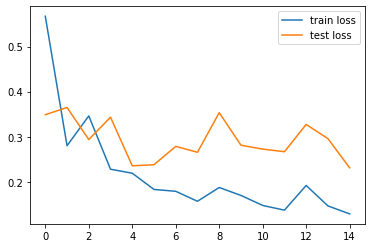

In [14]:
#Check train and test loss to see if we are overfitting
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend();

In [15]:
#Generate predictions for 1step and multistep forecasting
Ptrain=scaler.inverse_transform(model.predict(Xtrain))
Ptest=scaler.inverse_transform(model.predict(Xtest))


df_filter.loc[train_idx,'ANN_1step_train']=Ptrain
df_filter.loc[test_idx,'ANN_1step_test']=Ptest


multistep_predictions=[]

last_x=Xtest[0]

while len(multistep_predictions) < Samtest:
    p=model.predict(last_x.reshape(1,-1))[0]
    
    multistep_predictions.append(p)
    
    last_x=np.roll(last_x,-1)
    last_x[-1]=p
    
#Update the original dataframe with the multi-step forecast results
df_filter.loc[test_idx,'ANN_multistep']=scaler.inverse_transform(multistep_predictions)


In [16]:
#create ANN for multioutput predictions
i=Input(shape=(T,))
x=Dense(512,activation='selu')(i)
x=Dense(Samtest)(x)
model=Model(i,x)

model.compile(loss='mse',optimizer='adam',metrics='mse',)

r=model.fit(Xtrain_m,Ytrain_m,epochs=10,batch_size=128,validation_data=(Xtest_m,Ytest_m))

Epoch 1/10
5/5 [==============================] - 1s 36ms/step - loss: 1.2695 - mse: 1.2695 - val_loss: 0.5829 - val_mse: 0.5829
Epoch 2/10
5/5 [==============================] - 0s 8ms/step - loss: 0.6577 - mse: 0.6577 - val_loss: 0.9120 - val_mse: 0.9120
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6493 - mse: 0.6493 - val_loss: 0.9321 - val_mse: 0.9321
Epoch 4/10
5/5 [==============================] - 0s 10ms/step - loss: 0.5786 - mse: 0.5786 - val_loss: 0.7039 - val_mse: 0.7039
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.5196 - mse: 0.5196 - val_loss: 0.5603 - val_mse: 0.5603
Epoch 6/10
5/5 [==============================] - 0s 8ms/step - loss: 0.4986 - mse: 0.4986 - val_loss: 0.4871 - val_mse: 0.4871
Epoch 7/10
5/5 [==============================] - 0s 7ms/step - loss: 0.4839 - mse: 0.4839 - val_loss: 0.4809 - val_mse: 0.4809
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.4686 - mse: 0.4686 - val_loss:

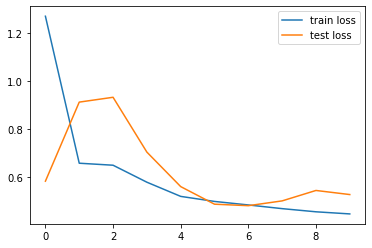

In [17]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend();

In [18]:

Ptrain=scaler.inverse_transform(model.predict(Xtrain_m))
Ptest=scaler.inverse_transform(model.predict(Xtest_m))

Ptrain=Ptrain[:,0]
Ptest=Ptest[0]

df_filter.loc[test_idx,'ANN_multioutput']=Ptest

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.28158193166674766
multistep_predictions RMSE: 0.40663152380434947
multioutput RMSE: 0.42526148310545914


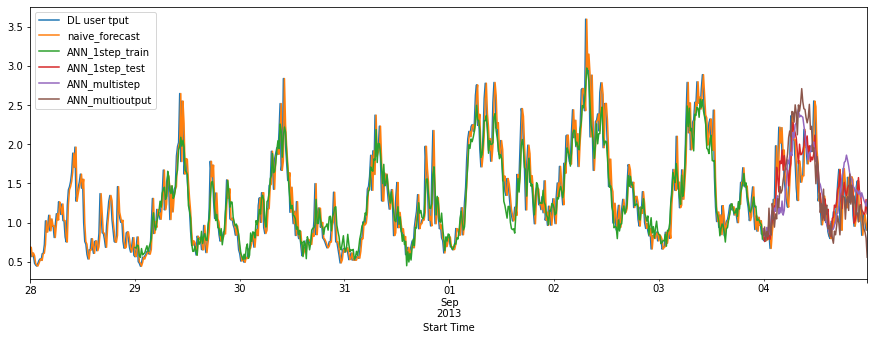

In [19]:

RMSE0=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,'naive_forecast']))

print("naive forecast RMSE:",RMSE0)

RMSE1=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,'ANN_1step_test']))

print("1-step_predictions RMSE:",RMSE1)

RMSE2=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,'ANN_multistep']))

print("multistep_predictions RMSE:",RMSE2)

RMSE3=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,'ANN_multioutput']))

print("multioutput RMSE:",RMSE3)

cols=['DL user tput','naive_forecast','ANN_1step_train','ANN_1step_test','ANN_multistep','ANN_multioutput']
df_filter[cols].plot(figsize=(15,5))


We see from above the results for the three types of forecasts. They are comparable to linear regression. Better results could be acheived with hyper-parameter tuning.

Since the above procedure is repetitive, it is worth while to create a workflow for it as below

In [20]:
def NN_forecast(model_1step,model_multioutput,name,epoch1=35,epoch2=35):
    #Create a train and test sets. The test set is one full day as before (96 samples)

    Samtest=96
    train=df_filter.iloc[:-Samtest]
    test=df_filter.iloc[-Samtest:]


    scaler=StandardScaler()
    train_scaled=scaler.fit_transform(train[['DL user tput']])
    test_scaled=scaler.transform(test[['DL user tput']])


    train_idx=df_filter.index <= train.index[-1]
    test_idx=df_filter.index > train.index[-1]

    df_filter.loc[train_idx,'scaled_tput']=train_scaled
    df_filter.loc[test_idx,'scaled_tput']=test_scaled

    #Put the user tput column in a numpy array. Not really required but working with numpy arrays is usually easier

    series=df_filter['scaled_tput'].to_numpy()

    #T is size of our inputs, which in our case is the previous 96 data points.
    #X and Y are empty lists and are placeholders for our input and output

    T=96
    X=[]
    Y=[]

    # Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
    #append the X and Y lists

    for t in range(len(series)-T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)

    #put back X and Y into arrays and reshape X as T inputs
    X=np.array(X).reshape(-1,T)
    Y=np.array(Y)


    #create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
    Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
    Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


    #Create and index for train and test from the original dataframe.
    #Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

    train_idx=df_filter.index <= train.index[-1]
    test_idx=~train_idx
    train_idx[:T]=False

    #Train the ML model...

    lr1=model_1step
    check_point=ModelCheckpoint('best_model1.h5',monitor='val_loss',save_best_only=True)
    r1=lr1.fit(Xtrain,Ytrain,epochs=epoch1,callbacks=[check_point],verbose=False,validation_data=(Xtest,Ytest))

    figure, axis = plt.subplots(2,1)
    axis[0].plot(r1.history['loss'],label='train loss')
    axis[0].plot(r1.history['val_loss'],label='test loss')
    axis[0].legend()
    
    best_model1=tf.keras.models.load_model('best_model1.h5')

    #generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
    # the train and test indicies

    Ptrain=scaler.inverse_transform(best_model1.predict(Xtrain))
    Ptest=scaler.inverse_transform(best_model1.predict(Xtest))


    df_filter.loc[train_idx,f'{name}_1step_train']=Ptrain
    df_filter.loc[test_idx,f'{name}_1step_test']=Ptest


    #Multi-step predictions: Create an empty list as a placeholder for the multi-step results
    #Set the first datapoint in test as the last known sample
    #generate predictions by using a while loop (as long as the muilt-step results list is 
    #less than the Samtest forecast horizon) and append every output to the list
    #Update the last known sample by setting it to the predicted value and repeat up to Samtest times


    multistep_predictions=[]

    last_x=Xtest[0]

    while len(multistep_predictions) < Samtest:
        p=best_model1.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x=np.roll(last_x,-1)
        last_x[-1]=p

    #Update the original dataframe with the multi-step forecast results
    
    df_filter.loc[test_idx,f'{name}_multistep']=scaler.inverse_transform(multistep_predictions)

    del lr1


    #Multi-output predictions: In the multi-output case the input samples are the same but the output
    #is a vector of values rather than a single value. In this the input is Tx (T as before)
    #but the output is Ty and is set to the full length of the test horizon Samtest

    Tx=T
    Ty=Samtest
    X=[]
    Y=[]

    #Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

    for t in range(len(series)-Tx-Ty+1):
        x=series[t:t+Tx]
        X.append(x)
        y=series[t+Tx:t+Tx+Ty]
        Y.append(y)

    #X and Y are put back into array form and reshaped
    X=np.array(X).reshape(-1,Tx)
    Y=np.array(Y).reshape(-1,Ty)


    #A new set of train and test sets are created for the multi-output case from X and Y
    Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
    Xtest_m,Ytest_m=X[-1:],Y[-1:]

    #ML model trained again on the new dataset
    lr2=model_multioutput
    print("Training Multi-output model")
    check_point=ModelCheckpoint('best_model2.h5',monitor='val_loss',save_best_only=True)
    r2=lr2.fit(Xtrain_m,Ytrain_m,epochs=epoch2,callbacks=[check_point],batch_size=128,verbose=False,validation_data=(Xtest_m,Ytest_m))

    
    axis[1].plot(r2.history['loss'],label='train loss')
    axis[1].plot(r2.history['val_loss'],label='test loss')
    axis[1].legend()
    plt.show()


    best_model2=tf.keras.models.load_model('best_model2.h5')
    
    #multi-output predictions generated and placed into the origial dataframe
    Ptrain=scaler.inverse_transform(best_model2.predict(Xtrain_m))
    Ptest=scaler.inverse_transform(best_model2.predict(Xtest_m))

    Ptrain=Ptrain[:,0]
    Ptest=Ptest[0]

    df_filter.loc[test_idx,f'{name}_multioutput']=Ptest

    del lr2

    #Plot the output for the 1-step,multi-step, and multi-output

    cols=['DL user tput','naive_forecast',f'{name}_multistep',f'{name}_1step_test',f'{name}_multioutput']
    df_filter[cols].plot(figsize=(15,5))


    RMSE0=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,'naive_forecast']))

    print("naive forecast RMSE:",RMSE0)

    RMSE1=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,f'{name}_1step_test']))

    print("1-step_predictions RMSE:",RMSE1)

    RMSE2=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,f'{name}_multistep']))

    print("multistep_predictions RMSE:",RMSE2)

    RMSE3=np.sqrt(mean_squared_error(df_filter.loc[test_idx,'DL user tput'],df_filter.loc[test_idx,f'{name}_multioutput']))

    print("multioutput RMSE:",RMSE3)

Let's run it with the same ANN architecture

Training Multi-output model


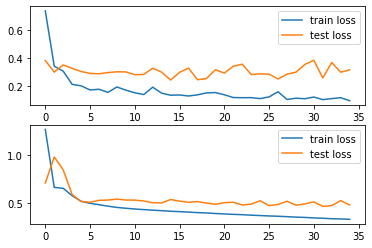

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.28883859574798726
multistep_predictions RMSE: 0.44244325147114744
multioutput RMSE: 0.3994740015723197


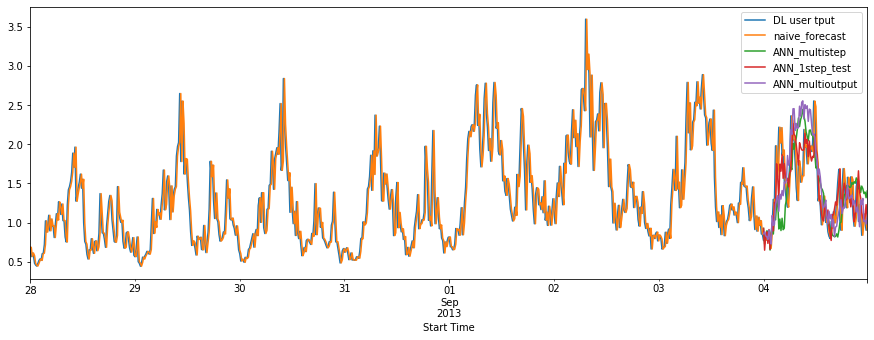

In [21]:
i=Input(shape=(T,))
x=Dense(512,activation='selu')(i)
#x=Dense(1024,activation='relu')(x)
x=Dense(1)(x)
model1=Model(i,x)

model1.compile(loss='mse',optimizer=keras.optimizers.Adam(),metrics='mse',)


#create ANN for multioutput predictions
i=Input(shape=(T,))
x=Dense(512,activation='selu')(i)
x=Dense(Samtest)(x)
model2=Model(i,x)

model2.compile(loss='mse',optimizer='adam',metrics='mse',)

NN_forecast(model1,model2,"ANN")

### Convolutional Neural Networks

Convolutional Neural Networks mainly use kernel filters of variable sizes to find patterns in the data. The parameters of the filters are learned thorugh the training process. for time series we use 1-dimensional filters followed by max pooling. We can follow that at the end of the hidden layers by either using global max pooling or simply flattening

Training Multi-output model


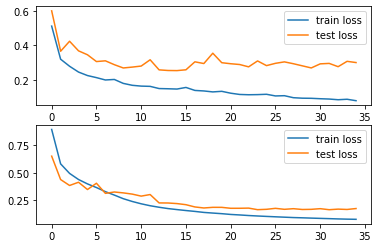

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.2957610860898859
multistep_predictions RMSE: 0.43401588269283425
multioutput RMSE: 0.2390558221304707


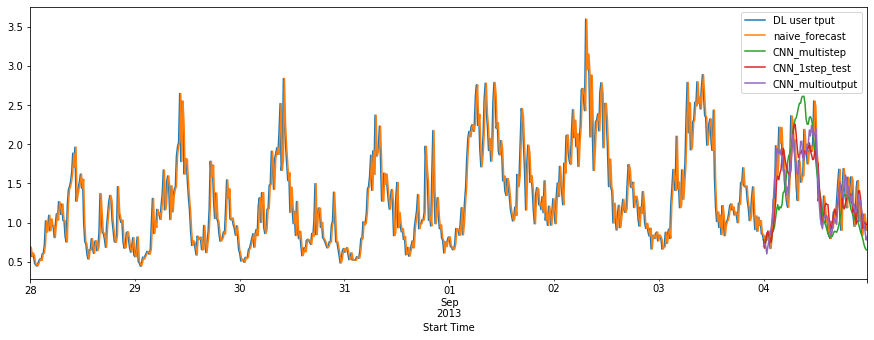

In [ ]:
#CNN

i=Input(shape=(T,1))
x=Conv1D(128,7,activation='selu')(i)
x=MaxPooling1D(3)(x)
#x=Conv1D(256,7,activation='relu')(x)
x=Flatten()(x)
#x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model1=Model(i,x)

model1.compile(loss='mse',optimizer=keras.optimizers.Adam(),metrics='mse',)


#create ANN for multioutput predictions
i=Input(shape=(T,1))
x=Conv1D(128,7,activation='relu')(i)
x=MaxPooling1D(3)(x)
x=Conv1D(256,7,activation='relu')(x)
x=Flatten()(x)
#x=GlobalMaxPooling1D()(x)
x=Dense(Ty)(x)
model2=Model(i,x)

model2.compile(loss='mse',optimizer='adam',metrics='mse',)

NN_forecast(model1,model2,"CNN")

### Recurrent Neural Networks

Recurrent Neural Networks are based on the idea of having the hidden layer built of RNNs, which are units that update the weights and biases based on current inputs as well as past states during the training process. This allows the neural network to remember past values in the sequence. This is why it is powerful in usecases that involve sequences. Their effectiveness in timeseries is a matter of debate and is always looked at from the perspective of balancing gains and losses (complexity vs performance gain).

The most commong type of RNNs are GRUs and LSTMs. More theoretical details to follow (TBD)

Training Multi-output model


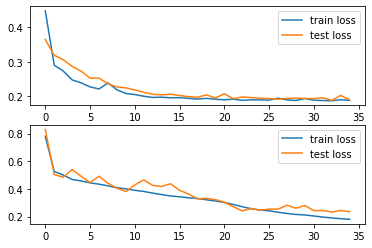

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.2531862173506042
multistep_predictions RMSE: 0.4336860960204286
multioutput RMSE: 0.2824277711599601


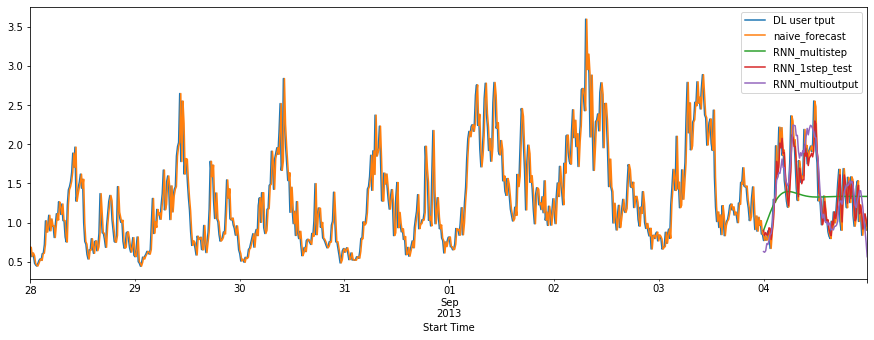

In [ ]:
i=Input(shape=(T,1))
x=LSTM(256)(i)
x=Dense(1)(x)
model1=Model(i,x)

model1.compile(loss='mse',optimizer=keras.optimizers.Adam(),metrics='mse',)


#create RNN for multioutput predictions
i=Input(shape=(T,1))
x=LSTM(128,return_sequences=True)(i)
x=Flatten()(x)
x=Dense(Ty)(x)
model2=Model(i,x)

model2.compile(loss='mse',optimizer='adam',metrics='mse',)

NN_forecast(model1,model2,"RNN")

Comparing the above results we can see that the best 1step forecasts performer was the RNN. For multistep/multi-output forecasts the best performer was the CNN. These results can vary based on hyper-parameter optimization (to follow)

The above architectures are the simplest that one can start with. A lot of parameters can be tried thorugh hyper-parameter optimization. Other aspects that could be tried are differencing as well as data transformations (logging before scaling for example).

Another important architecture that could be tried is the multi-tailed neural network, in particular in the context of multi-variate input. This will be covered in a separate notebook

### ANN with differencing (Apendix)

In [ ]:
def ANN_forecast_diff(name):
    
    #create a differenced column
    df_filter['1st_diff_tput']=df_filter['DL user tput'].diff()
    
    #Create a train and test sets. The test set is one full day as before (96 samples)

    Samtest=96
    train=df_filter.iloc[:-Samtest]
    test=df_filter.iloc[-Samtest:]

    #Put the 1st difference column instead of the DL user tput in a numpy array

    series=df_filter['1st_diff_tput'].to_numpy()[1:]

    #T is size of our inputs, which in our case is the previous 96 data points.
    #X and Y are empty lists and are placeholders for our input and output

    T=192
    X=[]
    Y=[]

    # Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
    #append the X and Y lists

    for t in range(len(series)-T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)

    #put back X and Y into arrays and reshape X as T inputs
    X=np.array(X).reshape(-1,T)
    Y=np.array(Y)

    

    #create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
    Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
    Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


    #Create and index for train and test from the original dataframe.
    #Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

    train_idx=df_filter.index <= train.index[-1]
    test_idx=~train_idx
    
    #set the train_index as False for T+1 instead of T as we have differenced values
    train_idx[:T+1]=False

    #Calculate the previous values required to make the predictions for the 1-step forecast
    df_filter['Shift_tput']=df_filter['DL user tput'].shift(1)
    prev=df_filter['Shift_tput']

    #get the last train data point required for multi-step and multi-output predictions
    last_train=train.iloc[-1]['DL user tput']
    
    #Train the ML model...

    #lr=model
    #lr.fit(Xtrain,Ytrain)

    i=Input(shape=(T,))
    x=Dense(32,activation='relu')(i)
    x=Dense(1)(x)
    model=Model(i,x)

    model.compile(loss='mse',optimizer='adam',metrics='mse',)

    r=model.fit(Xtrain,Ytrain,epochs=100,validation_data=(Xtest,Ytest))
    
    #generate naive forecasts
    
    df_filter['naive_forecast']=df_filter['DL user tput'].shift(1)
    df_filter['naive_forecast'][0]=df_filter['naive_forecast'][1]
    

    #generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
    # the train and test indicies. 1-step predictions are now based on the previous value + the predicted difference

    #df_filter.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+model.predict(Xtrain)
    #df_filter.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+model.predict(Xtest)




    Ptrain=model.predict(Xtrain).flatten()
    Ptest=model.predict(Xtest).flatten()

    df_filter.loc[train_idx,'Diff ANN Train Pred']=Ptrain
    df_filter.loc[test_idx,'Diff ANN Train Pred']=Ptest


    df_filter.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+Ptrain
    df_filter.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+Ptest


    #Multi-step predictions: Create an empty list as a placeholder for the multi-step results
    #Set the first datapoint in test as the last known sample
    #generate predictions by using a while loop (as long as the muilt-step results list is 
    #less than the Samtest forecast horizon) and append every output to the list
    #Update the last known sample by setting it to the predicted value and repeat up to Samtest times    


    multistep_predictions=[]

    last_x=Xtest[0]

    while len(multistep_predictions) < Samtest:
        p=model.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x=np.roll(last_x,-1)
        last_x[-1]=p

    #Update the original dataframe with the multi-step forecast results. The multi-step predictions are 
    #now the last train value + the accumulated predicted difference
    
    df_filter.loc[test_idx,f'{name}_multistep']=last_train+np.cumsum(multistep_predictions)


    #Multi-output predictions: In the multi-output case the input samples are the same but the output
    #is a vector of values rather than a single value. In this the input is Tx (T as before)
    #but the output is Ty and is set to the full length of the test horizon Samtest
    

    Tx=T
    Ty=Samtest
    X=[]
    Y=[]

    #Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

    for t in range(len(series)-Tx-Ty+1):
        x=series[t:t+Tx]
        X.append(x)
        y=series[t+Tx:t+Tx+Ty]
        Y.append(y)

    #X and Y are put back into array form and reshaped
    X=np.array(X).reshape(-1,Tx)
    Y=np.array(Y).reshape(-1,Ty)

    #A new set of train and test sets are created for the multi-output case from X and Y
    Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
    Xtest_m,Ytest_m=X[-1:],Y[-1:]

    #ML model trained again on the new dataset
    #lr=model
    #lr.fit(Xtrain_m,Ytrain_m)


    i=Input(shape=(T,))
    x=Dense(32,activation='relu')(i)
    x=Dense(Samtest)(x)
    model=Model(i,x)

    model.compile(loss='mse',optimizer='adam',metrics='mse',)

    r=model.fit(Xtrain_m,Ytrain_m,epochs=100,validation_data=(Xtest_m,Ytest_m))

    #multi-output predictions generated and placed into the origial dataframe. The multi-output predictions are again 
    #the last train value + the accumulated predicted difference

    Ptrain=model.predict(Xtrain_m)
    Ptest=model.predict(Xtest_m)

    Ptrain=Ptrain[:,0]
    Ptest=Ptest[0]

    df_filter.loc[test_idx,f'{name}_multioutput']= last_train + np.cumsum(Ptest)

    #Plot the output for the 1-step,multi-step, and multi-output

    cols=['DL user tput','naive_forecast',f'{name}_multistep',f'{name}_1step_test',f'{name}_multioutput']
    df_filter[cols].plot(figsize=(15,5))

    test_tput=df_filter.iloc[-Samtest:]['DL user tput']

    RMSE0=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,'naive_forecast']))

    print("naive forecast RMSE:",RMSE0)

    RMSE1=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_1step_test']))

    print("1-step_predictions RMSE:",RMSE1)

    RMSE2=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multistep']))

    print("multistep_predictions RMSE:",RMSE2)

    RMSE3=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multioutput']))

    print("multioutput RMSE:",RMSE3)

In [ ]:
ANN_forecast_diff("ANN")